## Is it a bird?

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# if iskaggle:
#     !pip install -U duckduckgo_search
#     !pip install fastai
#     !pip install fastbook
!pip install -U duckduckgo_search fastai fastbook

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

Use DuckDuckGo to search for images of "bird photos"
Use DuckDuckGo to search for images of "forest photos"
Fine-tune a pretrained neural network to recognise these two groups
Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS(headers = {"Accept-Encoding": "gzip, deflate, br"}) as ddgs:
        ddgs_images_gen = ddgs.images(term)
        count = 0
        ddgs_images_list = []
        while count < max_images:
            image = next(ddgs_images_gen)
            ddgs_images_list.append(image.get('image'))
            count = count+1
        return ddgs_images_list

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [32]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird', max_images=1)
urls[0]

Searching for 'bird'


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?auto=compress&cs=tinysrgb&dpr=3&h=750&w=1260'

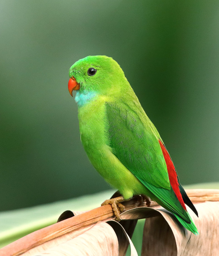

In [33]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photo'


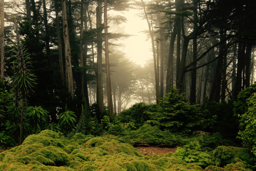

In [34]:
download_url(search_images('forest photo', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [35]:
from pathlib import Path

searches = ('bird', 'forest')
param = ('photo', 'sun photo', 'shade photo')

path = Path('model')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    for p in param:
        download_images(dest, urls=search_images(f'{o} {p}'))
        sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'


In [36]:
print(path)
searches = ('bird', 'forest')

for imageType in searches:
    print(imageType)
    content = os.listdir(path/imageType)
    for element in content:
        print(element)

model
bird
40e3a7ec-3ff5-4702-9e8a-c29140f4047b.jpg
eb218bcf-d13e-4548-9042-9ea55097edb1.jpg
dcfc6628-dbe8-4d9d-aa34-58ff0ea26427.jpg
2559388b-4e04-421c-b2e0-fe9923578183.jpg
ad74097a-d5f4-4a62-8a2a-e32329e55f29.jpeg
98a77b1d-c685-4f9b-9f56-93cfd51286ec.jpg
985d061e-de04-491a-86f7-96989621d227.jpg
0a944707-0cbc-46b9-89f8-5e230574d4e2.jpg
505f34f3-a29a-4359-970d-ee15f3d23678.jpg
32a877cc-f0e3-4477-beef-4ca24ee0ef66.jpg
1f43ad3b-20b8-48ce-942a-3d3cb256b3fd.jpg
555a9323-2c72-4465-b473-8d77b5e5982a.jpg
86c4d003-dccd-457a-beb6-b5e41013e3a1.jpg
0b2ddb4c-9c0d-42c7-99b4-7de85c564898.jpg
041fdbae-10e1-4393-bc4b-3fc8e3d90750.jpg
23ebc063-b080-479d-bc26-fc5bdec9e441.jpg
8f676316-cde0-45cc-9cb3-f73472aca980.jpg
c5e09b96-36d3-40cd-909c-0fb75d671e84.jpg
72aa04f8-15af-45a2-822b-5c9fec24f2bc.jpg
83c2be7b-3a5f-418b-8fc6-f824bc98cb01.jpg
cb5bca41-631e-4763-90dc-2417f60af13f.jpg
d58bc2f8-1b0e-44bc-aed7-ecdc9268185f.jpg
58678ee1-ae12-4fe4-afef-ed965fb883cf.jpg
64e03aca-a287-4fb3-ab6a-047853d39104.jpg
a538

## Step 2: Train our model
Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [37]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

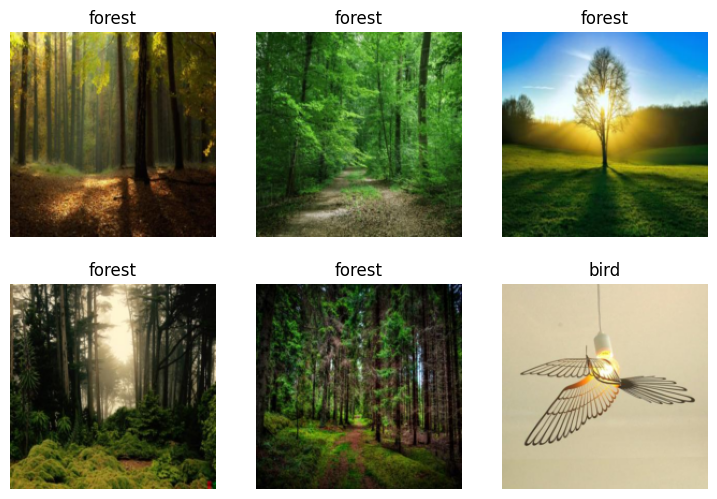

In [38]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

datablock.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [39]:
learn = vision_learner(datablock, resnet18, metrics=error_rate)
learn.fine_tune(3)

Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)
Let's see what our model thinks about that bird we downloaded at the start:

Searching for '갈매기'


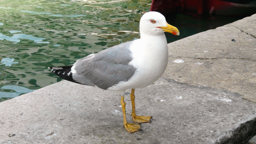

In [47]:
# in case of you do it again.
download_url(search_images('갈매기', max_images=1)[0], 'bird.jpg', show_progress=False)
Image.open('bird.jpg').to_thumb(256,256)

This is a: bird.
Probability it's a bird: 0.9998


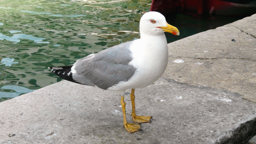

In [48]:
FILE_NAME = 'bird.jpg'
is_bird,_,probs = learn.predict(PILImage.create(FILE_NAME))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
Image.open(FILE_NAME).to_thumb(256,256)

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.